In [2]:
!pip install -U scikit-learn imbalanced-learn

    100% |████████████████████████████████| 7.1MB 6.4MB/s eta 0:00:01
    100% |████████████████████████████████| 163kB 39.6MB/s ta 0:00:01
    100% |████████████████████████████████| 296kB 38.3MB/s ta 0:00:01
Requirement not upgraded as not directly required: scipy>=0.17.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from scikit-learn) (1.4.1)
Requirement not upgraded as not directly required: numpy>=1.11.0 in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (from scikit-learn) (1.14.3)
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [102]:
%matplotlib inline

import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

import seaborn as sns
import numpy as np
import sklearn.metrics as metrics

from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE

#import autosklearn.classification
from sklearn.metrics import f1_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix


In [2]:
def get_x_y(df):
    return df.drop('isFraud', axis=1).values, df.isFraud.values

In [3]:
def undersample(df):
    # undersample dataset
    rus = RandomUnderSampler(random_state=42)
    X, y = rus.fit_resample(df.drop('isFraud', axis=1).values, df.isFraud.values)

    
    return pd.DataFrame(
        data=np.c_[ X, y ],
        columns=np.append( df.drop('isFraud', axis=1).columns.values, 'isFraud')
    )

In [4]:
def plot_classes(df):
    ax = df.groupby(df['isFraud'])['isFraud'].count().plot(kind='bar')
    x_offset = -0.05
    y_offset = 0
    for p in ax.patches:
        b = p.get_bbox()
        val = "{}".format(int(b.y1 + b.y0))
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

In [5]:
def plot_tsne(x_, y_):
    tsne = TSNE(n_components=2, random_state=0)
    X_2d = tsne.fit_transform(x_)
    plt.figure(figsize=(10,10))
    plt.scatter(X_2d[:,0], X_2d[:,1], color=['r' if y==1 else 'g' for y in y_])
    plt.show()

In [6]:
def plot_correlation(df_):
    corr = df_.corr()

    f, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(corr, annot=True, fmt="f",
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values,
                ax=ax)

In [7]:
def plot_money(df):
    plt.figure(figsize=(20,20))
    plt.subplot(10, 1, 1)
    df[(df.type_id == 0)].amount.plot.line(title='Amount NonFraud')

    plt.subplot(10, 1, 2)
    df[(df.type_id == 1)].amount.plot.line(color='r', title='Amount Fraud')

    plt.subplot(10, 1, 3)
    df[(df.type_id == 0)].oldbalanceOrg.plot.line(title='Old Balance Orig NonFraud')
    plt.subplot(10, 1, 4)
    df[(df.type_id == 1)].oldbalanceOrg.plot.line(color='r',title='Old Balance Orig Fraud')

    plt.subplot(10, 1, 5)
    df[(df.type_id == 0)].newbalanceOrig.plot.line(title='New Balance Orig NonFraud')
    plt.subplot(10, 1, 6)
    df[(df.type_id == 1)].newbalanceOrig.plot.line(color='r',title='New Balance Orig Fraud')


    plt.subplot(10, 1, 7)
    df[(df.type_id == 0)].oldbalanceOrg.plot.line(title='Old Balance Orig NonFraud')
    plt.subplot(10, 1, 8)
    df[(df.type_id == 1)].oldbalanceOrg.plot.line(color='r',title='Old Balance Orig Fraud')

    plt.subplot(10, 1, 9)
    df[(df.type_id == 0)].newbalanceOrig.plot.line(title='New Balance Orig NonFraud')
    plt.subplot(10, 1, 10)
    df[(df.type_id == 1)].newbalanceOrig.plot.line(color='r',title='New Balance Orig Fraud')

    plt.show()

In [106]:
def plot_confusion(y_predicted, y_truth):
    cnf_matrix = confusion_matrix(y_truth, y_predicted)

    f, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(cnf_matrix, annot=True, fmt="f", mask=np.zeros_like(cnf_matrix, dtype=np.bool), 
                cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    plt.show()

In [103]:
def plot_auc(y_predicted, y_truth):
    # calculate the fpr and tpr for all thresholds of the classification

    fpr, tpr, threshold = metrics.roc_curve(y_truth, y_predicted)
    roc_auc = metrics.auc(fpr, tpr)


    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Get the dataset if needed

In [9]:
if not os.path.exists('data'):
    !mkdir -p data/
    !cd data && curl -O https://spock.cloud/ai-workshop/datasets/credit-card/transactions.test.csv
    !cd data && curl -O https://spock.cloud/ai-workshop/datasets/credit-card/transactions.training.csv
    !cat data/transactions.training.csv > data/transactions.csv
    !grep -v 'isFraud' data/transactions.test.csv  >> data/transactions.csv 

## Load and prepare the dataset

In [10]:
df = pd.read_csv('data/transactions.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1


### Let's take a look on the incidency cases of fraudulent transactions with the same accounts

In [11]:
df_fraud = df[df.isFraud == 1]

In [12]:
df_fraud[['nameOrig', 'isFraud']].groupby(['nameOrig']).isFraud.value_counts().nlargest(15)

nameOrig     isFraud
C1000036340  1          1
C1000086512  1          1
C1000331499  1          1
C1000484178  1          1
C1000513158  1          1
C1000937208  1          1
C1001502110  1          1
C1001765380  1          1
C1001875185  1          1
C1002446735  1          1
C1002859898  1          1
C1002895272  1          1
C1003023037  1          1
C1003377863  1          1
C1003695704  1          1
Name: isFraud, dtype: int64

In [13]:
df_fraud[['nameDest', 'isFraud']].groupby(['nameDest']).isFraud.value_counts().nlargest(15)

nameDest     isFraud
C1013511446  1          2
C104038589   1          2
C105660024   1          2
C1148781766  1          2
C1185292292  1          2
C1193568854  1          2
C1259079602  1          2
C1325541393  1          2
C1366192319  1          2
C1399829166  1          2
C14138104    1          2
C1460854172  1          2
C1497532505  1          2
C1601170327  1          2
C1650668671  1          2
Name: isFraud, dtype: int64

The incidency is very low... The linear correlation will be low too. So, let's ignore these two columns and make the model more generic and simpler

### Ok. To check the correlation, let's transform some textual features to int and plot the correlation matrix

In [14]:
df['type'] = df['type'].astype('category')
df['type_id'] = df.type.cat.codes

In [15]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,type_id
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,4
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,1
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,4
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,1
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,4


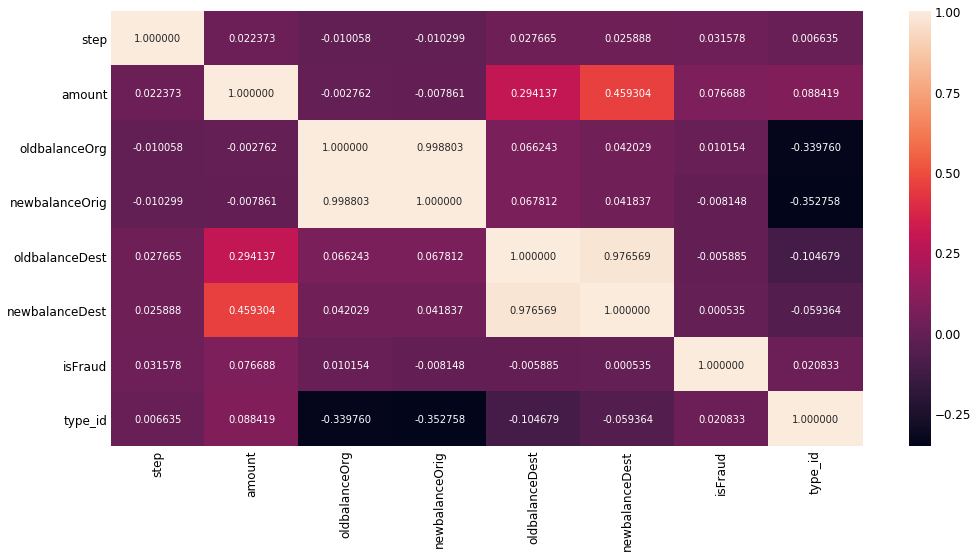

In [16]:
plot_correlation(df)

In [17]:
useless_features = ['type', 'step', 'nameOrig', 'nameDest']

In [36]:
df = df.drop(useless_features, axis=1)

### Plot the class distribution

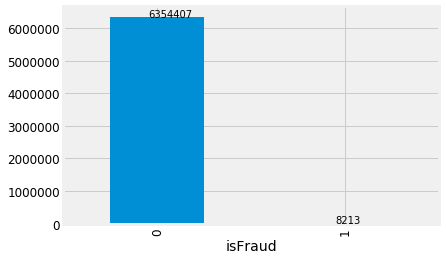

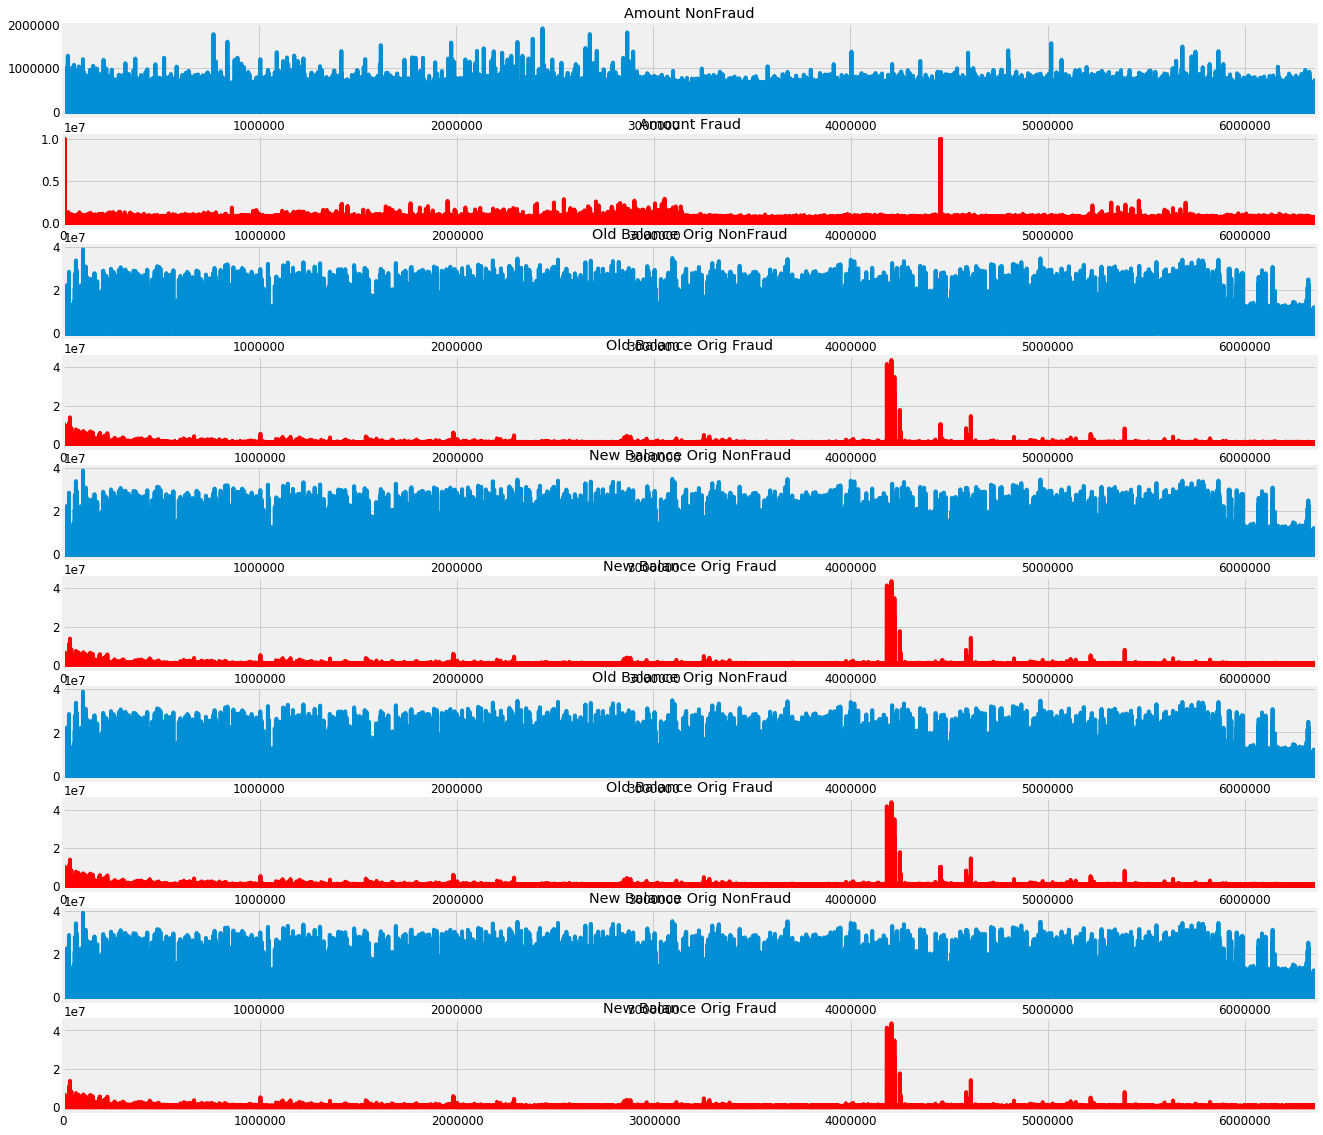

(None, None)

In [37]:
plot_classes(df),plot_money(df)

### A basic undersampling experiment for balancing the dataset

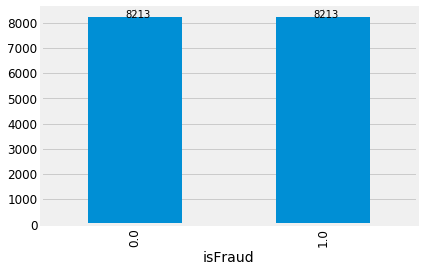

In [38]:
df_balanced = undersample(df)
plot_classes(df_balanced)

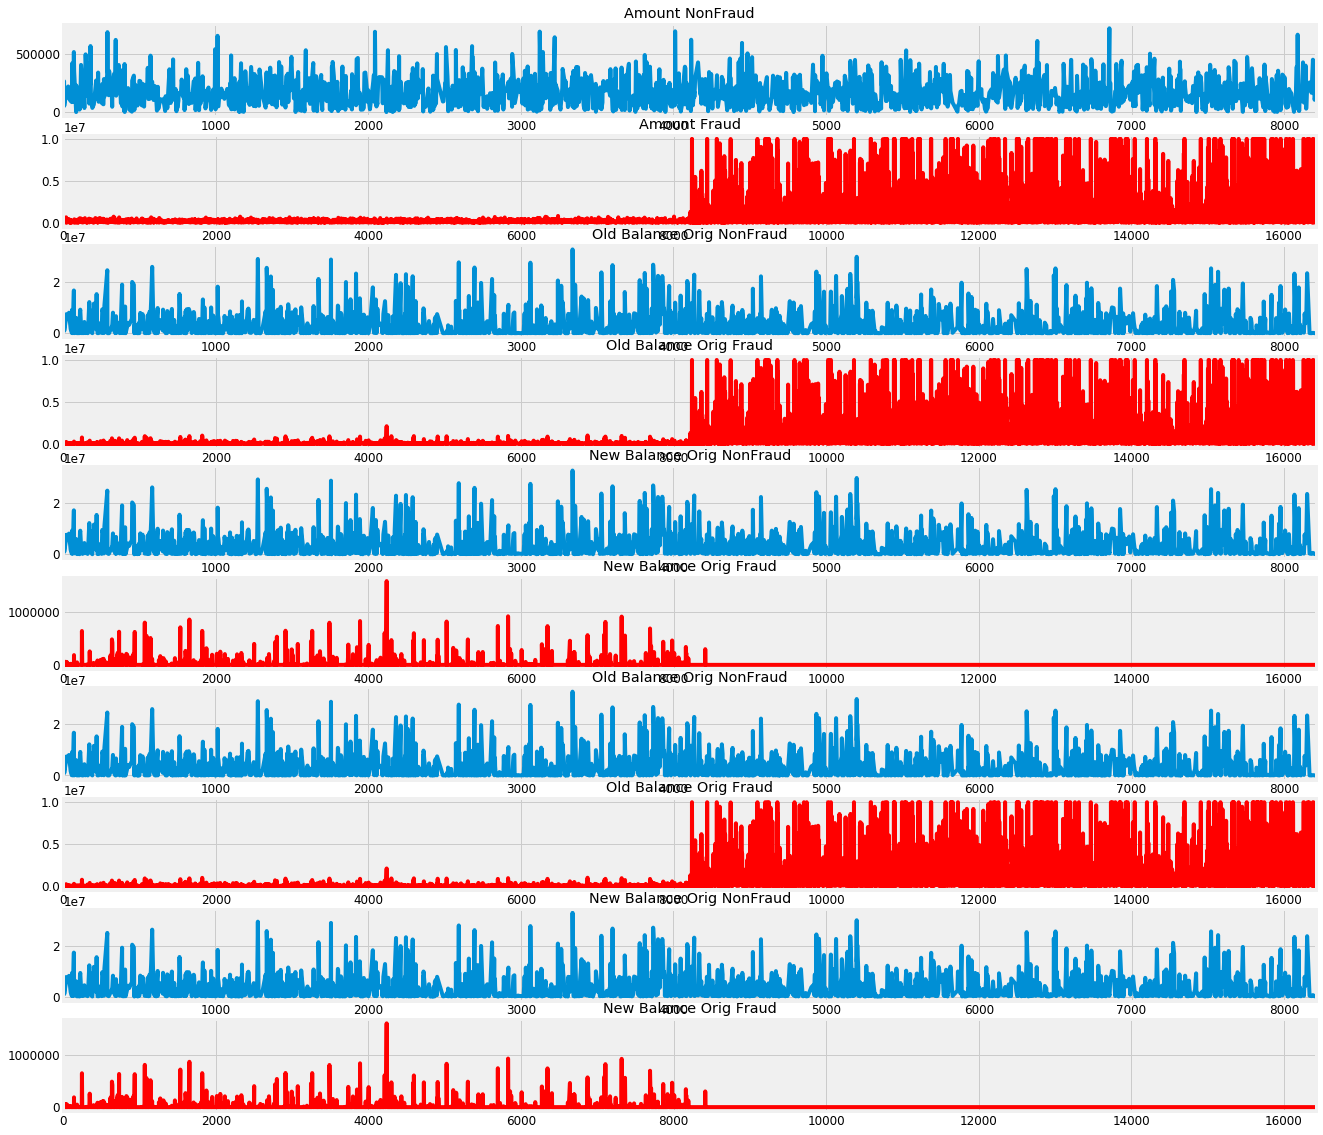

In [20]:
plot_money(df_balanced)

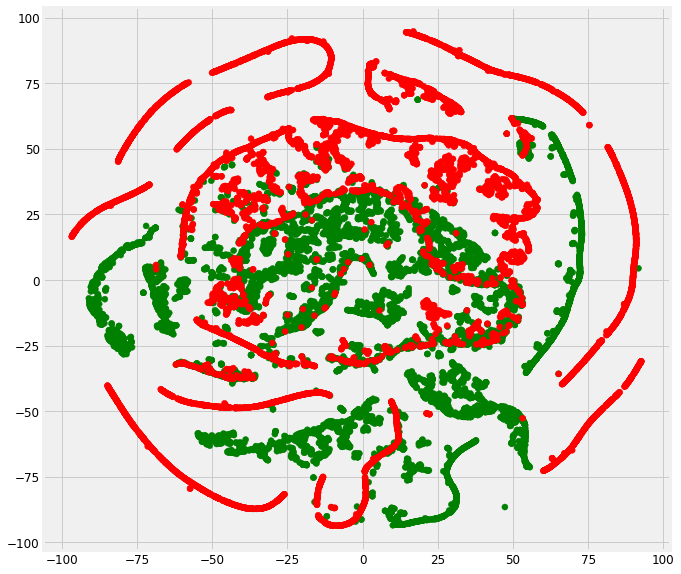

In [21]:
X,y = get_x_y(df_balanced)
plot_tsne(X,y)

## Now, let's train and test the final XGBoost model

In [39]:
from sklearn.model_selection import train_test_split
X,y = get_x_y(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

X_balanced,y_balanced = get_x_y(df_balanced)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.33, random_state=42, stratify=y_balanced)

In [40]:
with open('fraud_train.csv', 'w') as csv:
    for x_,y_ in zip(X_train, y_train):
        line = "%s,%s" % (y_, ",".join( list(map(str, x_)) ) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

with open('fraud_test.csv', 'w') as csv:
    for x_,y_ in zip(X_test, y_test):
        line = "%s,%s" % (y_, ",".join( list(map(str, x_)) ) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

#### We'll split (only) the features here into small batches in order to use these files in a multi-host batch transform job

In [41]:
with open('fraud_test_batch.csv', 'w') as csv:
    for x_ in X_test:
        line = ",".join( list(map(str, x_) ) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

!rm -rf batch    
!mkdir -p batch
!cd batch && split -l 55000 --additional-suffix='.csv' ../fraud_test_batch.csv fraud_test_batch_
!rm -f fraud_test_batch.csv

In [42]:
with open('fraud_test_batch_balanced.csv', 'w') as csv:
    for x_ in X_test_balanced:
        line = ",".join( list(map(str, x_) ) )
        csv.write( line + "\n" )
    csv.flush()
    csv.close()

!rm -rf batch_balanced    
!mkdir -p batch_balanced
!cd batch_balanced && split -l 55000 --additional-suffix='.csv' ../fraud_test_batch_balanced.csv fraud_test_batch_
!rm -f fraud_test_batch_balanced.csv

## Ok, now that our datasets are ready, let's upload the files to S3 and start training/predicting

In [29]:
import sagemaker
import boto3

from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

role = get_execution_role()

prefix='fraud_detection'
# Retrieve the default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

In [57]:
# Upload the dataset to an S3 bucket
input_train = sagemaker_session.upload_data(path='fraud_train.csv', key_prefix='%s/data' % prefix)
input_test = sagemaker_session.upload_data(path='fraud_test.csv', key_prefix='%s/data' % prefix)

In [45]:
data_path="s3://%s/%s/data/batch" % (bucket, prefix)
!aws --quiet s3 rm --recursive $data_path
input_test_batch = sagemaker_session.upload_data(path='batch', key_prefix='%s/data/batch' % prefix)

In [46]:
data_path="s3://%s/%s/data/batch_balanced" % (bucket, prefix)
!aws --quiet s3 rm --recursive $data_path
input_test_batch_balanced = sagemaker_session.upload_data(path='batch_balanced', key_prefix='%s/data/batch_balanced' % prefix)

In [60]:
train_data = sagemaker.session.s3_input(s3_data=input_train,content_type="csv")
test_data = sagemaker.session.s3_input(s3_data=input_test,content_type="csv")

#### Compute the labels weight, since this is a very unbalanced dataset

In [48]:
total_fraud=int(np.sum(y_train))
total_non_fraud=len(y_train)-total_fraud

scale_pos_weight=total_non_fraud/total_fraud
print('Pos Weight scale: %f' % scale_pos_weight)

Pos Weight scale: 773.660185


In [53]:
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'}

# Create the estimator
xgb = sagemaker.estimator.Estimator(containers[boto3.Session().region_name],
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.4xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)
# Set the hyperparameters
xgb.set_hyperparameters(eta=0.1,
                        max_depth=40,
                        gamma=4,
                        reg_lambda=10,
                        alpha=10,
                        min_child_weight=6,
                        silent=0,
                        scale_pos_weight=scale_pos_weight,
                        objective='binary:logistic',
                        num_round=150)

In [61]:
%%time
# takes around 3min 11s
xgb.fit({'train': train_data, 'validation': test_data, })

2020-03-25 11:13:33 Starting - Starting the training job...
2020-03-25 11:13:35 Starting - Launching requested ML instances......
2020-03-25 11:14:36 Starting - Preparing the instances for training...
2020-03-25 11:15:21 Downloading - Downloading input data...
2020-03-25 11:15:58 Training - Training image download completed. Training in progress.Arguments: train
[2020-03-25:11:15:58:INFO] Running standalone xgboost training.
[2020-03-25:11:15:58:INFO] File size need to be processed in the node: 268.21mb. Available memory size in the node: 23314.43mb
[2020-03-25:11:15:58:INFO] Determined delimiter of CSV input is ','
[11:15:58] S3DistributionType set as FullyReplicated
[11:15:59] 4262955x6 matrix with 25577730 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-03-25:11:15:59:INFO] Determined delimiter of CSV input is ','
[11:15:59] S3DistributionType set as FullyReplicated
[11:15:59] 2099665x6 matrix with 12597990 entries loaded from /opt/ml/input/d

[11:17:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 602 extra nodes, 62 pruned nodes, max_depth=28
[37]#011train-error:0.002664#011validation-error:0.002703
[11:17:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 572 extra nodes, 62 pruned nodes, max_depth=35
[38]#011train-error:0.002617#011validation-error:0.002665
[11:17:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 578 extra nodes, 72 pruned nodes, max_depth=22
[39]#011train-error:0.002561#011validation-error:0.002616
[11:17:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 554 extra nodes, 72 pruned nodes, max_depth=25
[40]#011train-error:0.002505#011validation-error:0.002556
[11:17:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 594 extra nodes, 62 pruned nodes, max_depth=26
[41]#011train-error:0.002465#011validation-error:0.002518
[11:17:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 644 extra nodes, 96 pruned nodes, max_depth=29
[42]#011train-error:

[11:19:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 302 extra nodes, 292 pruned nodes, max_depth=32
[83]#011train-error:0.001321#011validation-error:0.001391
[11:19:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 328 extra nodes, 296 pruned nodes, max_depth=29
[84]#011train-error:0.001308#011validation-error:0.001378
[11:19:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 146 pruned nodes, max_depth=40
[85]#011train-error:0.001297#011validation-error:0.001367
[11:19:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 216 extra nodes, 144 pruned nodes, max_depth=40
[86]#011train-error:0.001287#011validation-error:0.001357
[11:19:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 200 extra nodes, 128 pruned nodes, max_depth=40
[87]#011train-error:0.001277#011validation-error:0.001345
[11:19:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 270 extra nodes, 124 pruned nodes, max_depth=39
[88]#011train-

[11:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 332 pruned nodes, max_depth=16
[129]#011train-error:0.001041#011validation-error:0.001105
[11:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 138 extra nodes, 320 pruned nodes, max_depth=27
[130]#011train-error:0.00104#011validation-error:0.001103
[11:21:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 168 extra nodes, 214 pruned nodes, max_depth=40
[131]#011train-error:0.001035#011validation-error:0.001095
[11:21:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 164 extra nodes, 282 pruned nodes, max_depth=39
[132]#011train-error:0.001032#011validation-error:0.00109
[11:21:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 176 extra nodes, 266 pruned nodes, max_depth=40
[133]#011train-error:0.001026#011validation-error:0.001086
[11:21:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 340 pruned nodes, max_depth=18
[134]#011tra

In [62]:
import glob
def launch_batch_prediction(input_path, output_dir):
    transformer = xgb.transformer(
        instance_count=5, 
        instance_type='ml.c5.xlarge',
        output_path="s3://%s/%s/%s" % ( bucket, prefix, output_dir ),
        max_payload=5, # 5MB
        accept='text/csv',
        #max_concurrent_transforms=1000, 
    )
    transformer.transform(
        input_path, 
        data_type='S3Prefix',                  
        content_type='text/csv', 
        split_type='Line',
        wait=True
    )

def load_dataframe_from_batch(ground_truth_labels, output_dir):
    batch_output_dir="s3://%s/%s/%s" % ( bucket, prefix,output_dir )
    !rm -rf batch_result
    !aws --quiet s3 sync $batch_output_dir batch_result

    all_files = sorted(glob.glob( "batch_result/*.out"))
    li = [pd.read_csv(x, index_col=None, names=['is_fraud']) for x in all_files]

    result_df = pd.concat(li, sort=False, axis=0, ignore_index=True)
    result_df.is_fraud = result_df.is_fraud.astype(np.float64)
    result_df['ground_truth'] = ground_truth_labels
    return result_df

def adjust_threshold(df, thresh):
    df['predicted'] = df.is_fraud.apply(lambda x: 1 if x > thresh else 0)
    return df

In [ ]:
launch_batch_prediction( input_test_batch, 'batch_output')
launch_batch_prediction( input_test_batch_balanced, 'batch_output_balanced')

...................................

In [89]:
result_df = load_dataframe_from_batch(y_test, 'batch_output')
result_df_balanced = load_dataframe_from_batch(y_test_balanced,'batch_output_balanced')

F1 score: 88.094332


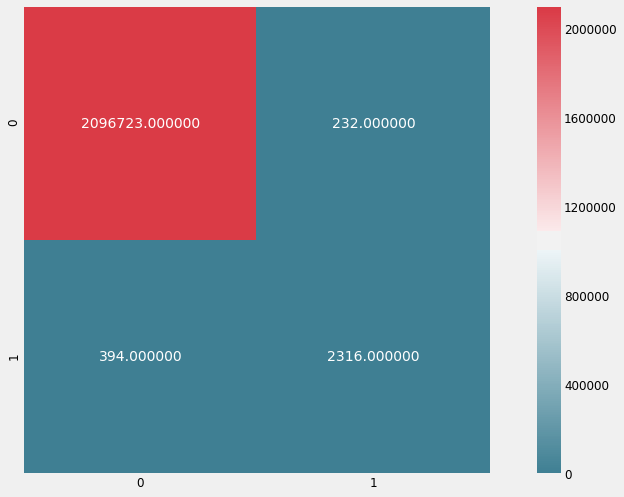

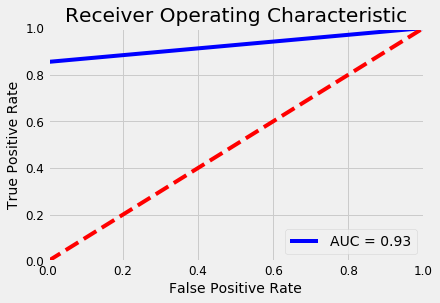

In [110]:
result_df = adjust_threshold(result_df, 0.993)
predicted = result_df.predicted.values
ground_truth = result_df.ground_truth.values
f1 = f1_score(ground_truth, predicted, labels=[True, False],average='binary')
print("F1 score: %f" % (f1 * 100))
plot_confusion(predicted, ground_truth)
plot_auc(predicted, ground_truth)

F1 score: 99.796936


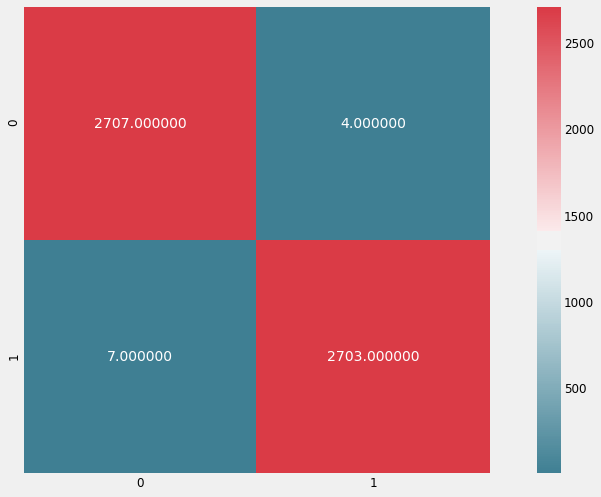

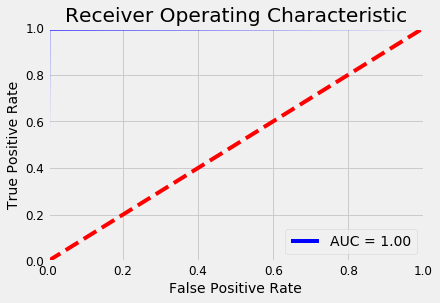

In [113]:
result_df_balanced = adjust_threshold(result_df_balanced, 0.1)
predicted = result_df_balanced.predicted.values
ground_truth = result_df_balanced.ground_truth.values
f1 = f1_score(ground_truth, predicted, labels=[True, False],average='binary')
print("F1 score: %f" % (f1 * 100))
plot_confusion(predicted, ground_truth)
plot_auc(predicted, ground_truth)